In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from scipy.stats import norm, uniform
from scipy.special import softmax, erf
from scipy.optimize import minimize, root

# Andmed
Aasta 2023 juulist septembrini kestnud sõduri baaskursuse ajal kirja pandud spioonide ning ka mittespioonide toimumiskuupäevad ning -ajad. 

In [2]:
def build_df(filename: str) -> pl.DataFrame:
    return pl.read_csv(filename, try_parse_dates=True).with_columns(
        (pl.col('kuupäev') - pl.col('kuupäev').dt.strftime('%Y-%m-%d').str.strptime(pl.Datetime)).dt.total_minutes().alias('t'),
        pl.col('kuupäev').dt.ordinal_day().alias('m')).with_columns(
        pl.first('m').over('m').rank('dense').alias('m') - 1
    ).drop('kuupäev')

In [3]:
df = build_df('andmed/spioonid.csv')
df.head()

t,m
i64,u32
851,0
1050,0
1112,0
1294,0
1325,0


# Taust
Kirjeldatud meetod põhineb täielikult [Goulding et al.](https://www.cs.nott.ac.uk/~pszgss/goulding2016event_preprint.pdf)

Mittehomogeenset Poissoni protsessi kirjeldab ajast sõltuv intensiivsus $\lambda(t)$, see on ka näide loendavast protsessist, mida on võimalik defineerida kahe ajahetke $t_1$ ning $t_2$ vaheliste sündmuste arvu esinemise tõenäosuse kaudu
\begin{align*}
    &P(N(t_1, t_2) = c) = \frac{ \Lambda(t_1, t_2)^c}{c!} e^{- \Lambda(t_1, t_2)} \\
    \text{kus} \quad &\Lambda(t_1, t_2) = \int_{t_1}^{t_2} \lambda(t) dt
\end{align*}
Intensiivsusfunktsiooni kaudu on võimalik avaldada jaotusfunktsioon $F^s(t)$, mis kirjeldab oodatavat aega hetkest $s$ kuni uue sündmuse toimumiseni
\begin{equation*}
    F^s(t) = 1 - e^{\Lambda(s, s + t)}
\end{equation*}
Jaotusfunktsiooni on võimalik kasutada ennustamiseks, lisaks on selle põhjal võimalik leida sündmusrea $\textbf{t}_i = \langle t_{i0} , t_{i1} , \dots , t_{ij} \rangle$ ühisjaotuse tihedus $f(\textbf{t}_i)$, mis kirjeldab tõenäosust, et rida pärineb sellelt protsessilt.
\begin{equation*}
    f(\textbf{t}_i | \tau) = e^{- \Lambda (0 , \tau) } \prod_{j = 1}^n \lambda (t_{ij})
\end{equation*}
kus $\tau$ tähistab protsessi indekshulga vähimat ülemist tõket.

# Mudel
Formaalselt võib eelnevat andmestikku kirjeldada sündmusridade hulgana $\mathcal{T} = \{ \textbf{t}_1 , \textbf{t}_2 , \dots , \textbf{t}_m \}$, mille realisatsioonid $\textbf{t}_i = \langle t_{i0} , t_{i1} , \dots , t_{ij} \rangle$ pärinevalt mingilt mittehomogeense Poissoni liitprotsessi alamprotsessilt.

Andmestikku modelleerime $Z$ alamprotsessist koosneva MHPP liitprotsessina, mille alamprotsesside intesiivsused on $K$ kaalutud normaaljaotustiheduste summad 
\begin{align*}
    &\lambda_z(t) = \sum_{k = 1}^K a_{z k} B_k(t) \\
    \text{kus} \quad &B_k(t) = \frac{1}{\sigma_k \sqrt{2 \pi}} \exp \left( - \frac{(t - \mu_k)^2}{2 \sigma_k^2} \right) \\
    \text{ning} \quad &\mu_k = \frac{(k - 1) \tau}{K - 1} , \qquad \sigma_k = \frac{\tau}{k} 
\end{align*}

In [4]:
n_bases = 20  # K
n_series = df['m'].n_unique()  # m
n_processes = 5  # Z

k = np.arange(1, n_bases + 1)
tau = df['t'].max()
locs = ((k - 1) * tau) / (n_bases - 1)
scales = tau / k

loc_kwargs = {'loc': locs, 
              'scale': scales}

In [5]:
def rate(x, weights):
    return np.sum(weights * norm.pdf(x, **loc_kwargs))


def joint_pdf(xs, weights):
    integral = np.sum(weights * norm.cdf(tau, **loc_kwargs))
    return np.exp(-integral) * np.prod([rate(x, weights) for x in xs])

## Parameetrite sobitamine
Toodud ehitusklotside põhjal taandub mudeli loomine kaalude $a_{zk}$ leidmisele. Kaalude leidmiseks vaatame parameetrite suhtes mudeli tõepära funktsiooni. Igale alamprotsessile $N_z(t)$ seame vastavusse segandumis tõenäosuse $p_z$, mis kirjedab võimalust, et mingi sündmusterida hulgas $\mathcal{T}$ pärineb sellelt alamprotsessilt. Eelnevast lähtudes on kogu mudeli tõepära funktsioon
\begin{equation*}
    \mathcal{L}(\theta | \mathcal{T}) = \prod_{i = 1}^m \sum_{z = 1}^Z p_z f_z(\textbf{t}_i | \tau)
\end{equation*}
kus $\theta = \langle \lambda_1 , \lambda_2 , \dots , \lambda_Z \rangle$.
Järgnevalt leiame mudeli kaalud iteratiivselt, kasuted EM (expectation maximization) meetodit. Alustades algsete parameetritega $\theta^0$ (siin tähistame $r$-indat iteratsioonisammu kujul $\theta^r$).

In [6]:
def negative_log_likelihood(weights, weights_shape, mix_probs, orig_probs, orig_probs_shape, data: pl.DataFrame):
    weights = weights.reshape(weights_shape)
    gp = data.group_by('m').all()
    
    likelihood = 0
    for i, z in np.ndindex(orig_probs_shape):
        t_vec = gp.row(by_predicate=(pl.col('m') == i))[1]
        likelihood += orig_probs[(i, z)] * np.log(mix_probs[z] * joint_pdf(t_vec, weights[z]))
    
    return -likelihood  # negate for maximization using `scipy.optimize.minimize`

### Ooteväärtuse samm
Antud parameetrivektori $\theta^r$ korral leiame iga alamprotsessi jaoks tõenäosused, et sündmuste rida $\textbf{t}_i$ pärineb sellelt alamprotsessilt
\begin{equation*}
    p_{iz}^r = \frac{ e^{- \Lambda_z (0 , \tau) } \prod_{j = 1}^n \lambda_z (t_{ij}) }{ \sum_{q = 1}^{Z} e^{- \Lambda_q (0 , \tau)} \prod_{j = 1}^n \lambda_q (t_{ij}) }
\end{equation*}

In [7]:
def expectation_step(data, orig_probs_shape, weights):
    orig_probs = np.zeros(orig_probs_shape)
    gp = data.group_by('m').all()
    
    for i, z in np.ndindex(orig_probs_shape):
        t_vec = gp.row(by_predicate=(pl.col('m') == i))[1]
        
        numerator = joint_pdf(t_vec, weights[z])
        denominator = np.sum([joint_pdf(t_vec, weights[q]) for q in range(n_processes)])
        
        orig_probs[(i, z)] = numerator / denominator
    
    return orig_probs

### Maksimeerimise samm
Saadud pärinemistõenäosustega leiame uued parameetrite lähendid $\theta^{r + 1}$ suurima logaritm tõepära meetodil
\begin{equation*}
    \theta^{r + 1} = \underset{\theta}{\arg \max} \left[ \sum_{i = 1}^m \sum_{z = 1}^Z p_{iz} \ln \left( p_z e^{- \Lambda_z (0 , \tau) } \prod_{j = 1}^n \lambda_z (t_{ij}) \right) \right]
\end{equation*}
paramaeetrid leiame numbriliselt.

Järgmised hinnangud segandumistõenäosustele leiame lihtsa aritmeetilise keskmisena pärinemistõenäosustest
\begin{equation*}
    p_z^{r + 1} = \frac{1}{n} \sum_{i = 1}^m p_{iz}^r
\end{equation*}

In [8]:
def maximisation_step(data: pl.DataFrame, weights, mix_probs, orig_probs):
    weights_shape = weights.shape
    theta = weights.flatten()
    
    args = (weights_shape, mix_probs, orig_probs, orig_probs.shape, data)
    bounds = ((1e-5, np.inf) for _ in theta)
    optimize_result = minimize(negative_log_likelihood, theta, args=args, bounds=bounds)
    
    weights = optimize_result['x'].reshape(weights_shape)
    mix_probs = orig_probs.mean(axis=0)
    
    return weights, mix_probs, optimize_result

EM meetodi iteratsioonisamme kordame kuni kindla sammude arvuni või koondumiseni

In [9]:
def em(data: pl.DataFrame, init_weights, num_series, num_subprocess, max_steps=10, diff_threshold=1e-4, verbose=False):
    orig_probs = softmax(np.zeros((num_series, num_subprocess), dtype=np.longdouble))
    mixing_probs = np.mean(orig_probs, axis=0)
    
    step = 0
    diff_norm = diff_threshold
    while step <= max_steps and diff_norm >= diff_threshold:
        orig_probs = expectation_step(data, orig_probs.shape, init_weights)
        weights, mixing_probs, _ = maximisation_step(data, init_weights, mixing_probs, orig_probs)
        
        if verbose:
            diff = weights - init_weights
            diff_norm = np.linalg.norm(diff, ord=np.inf)
            print(f'| step={step} \t| diff_norm={diff_norm} \t|')
        
        init_weights = weights
        step += 1
        
    return init_weights

In [10]:
initial_weights = uniform.rvs(0, 1, size=(n_processes, n_bases))
model_weights = em(df, initial_weights, n_series, n_processes, max_steps=15, verbose=True)

| step=0     | diff_norm=9.481979658291463     |
| step=1     | diff_norm=1.286737134953992     |
| step=2     | diff_norm=1.3922223104686124    |
| step=3     | diff_norm=1.8407777504895972    |
| step=4     | diff_norm=1.867819928028859     |
| step=5     | diff_norm=0.6732408536523401    |
| step=6     | diff_norm=0.3086145425968175    |
| step=7     | diff_norm=0.2206226686372475    |
| step=8     | diff_norm=0.1917263858992117    |
| step=9     | diff_norm=0.1736833329680832    |
| step=10    | diff_norm=0.2047859252864321    |
| step=11    | diff_norm=0.2305067254737253    |
| step=12    | diff_norm=0.2700433515478490    |
| step=13    | diff_norm=0.2409544197293561    |
| step=14    | diff_norm=0.2999073570749032    |
| step=15    | diff_norm=0.1990758262442984    |


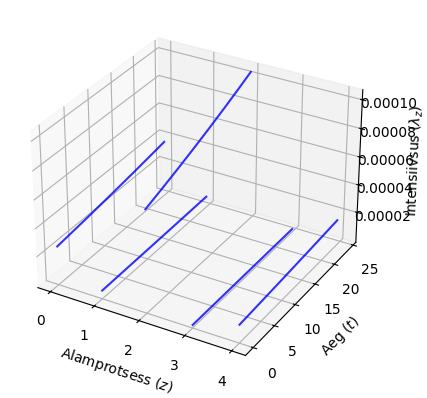

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for sub_process in range(n_processes):
    time = np.linspace(0, 24, 500)
    sub_process_rate = [rate(t, model_weights[sub_process]) for t in time]
    
    ax.plot(time, sub_process_rate, zs=sub_process, zdir='x', color='b', alpha=0.8)

ax.set_xlabel('Alamprotsess $(z)$')
ax.set_ylabel('Aeg $(t)$')
ax.set_zlabel('Intensiivsus $(\\lambda_z)$')

fig.savefig(f'joonised/mudel_z{n_processes}_k{n_bases}.png', dpi=100)

## Mudeli kasutamine
Ennustamaks järgmise sündmuse toimumishetke sündmusreas $\textbf{t}$, peame kõigepealt nimetatud sündmusrea seostama mudeli mingi alamprotsessiga. Soovitud alamprotsessi $z$ valime suurima tõepära meetodiga
\begin{equation*}
    z = \underset{z \in \{ 1 , 2 , \dots , Z \} }{\arg \max} f_z(\textbf{t} | \tau)
\end{equation*}

In [12]:
test_df = build_df('andmed/spioonid_kunstlik.csv')
test_times = test_df.group_by('m').all().row(by_predicate=(pl.col('m') == 5))[1]

sub_process = np.argmax([joint_pdf(test_times, model_weights[sub_process]) for sub_process in range(n_processes)])

### Aeg järgmise sündmuseni
Kui oleme leidnud võimalik sündmusrea tootnud alamprotsessi, ennustame aega järgmise sündmuse toimumiseni $\eta$ alamprotsessi jaotuse mediaanina
\begin{align*}
    F_z^s(\eta) = 1 - e^{\Lambda_z(s , s + \eta)} &= \frac{1}{2} \\
    \Lambda_z(s , s + \eta) - \ln 2 &= 0
\end{align*}

Tehes asendused ning integreerimse jõuame võrrandini
\begin{equation*}
    \sum_{k = 1}^K \frac{a_{zk}}{2} \left[ \text{erf} \left( \frac{s + \eta - \mu_k}{\sqrt{2} \sigma_k} \right) - \text{erf} \left( \frac{s - \mu_k}{\sqrt{2} \sigma_k} \right) \right] - \ln 2 = 0
\end{equation*}
Kuna kõik muutujad peale $\eta$ on teada, saame lähendi leida kiiresti kasutades numbrilisi meetodeid.

In [13]:
def cdf_expression(eta, from_t, process_weights, quantile=0.5):
    q_log = np.log(1 / quantile)
    scaled_weights = process_weights / 2
    numerator = from_t - locs
    denominator = np.sqrt(2) * scales
    return np.sum(scaled_weights * (erf((numerator + eta) / denominator) - erf(numerator / denominator))) - q_log

In [14]:
from_time = 16.5 * 60
root_result = root(cdf_expression, np.array([0]), args=(from_time, model_weights[sub_process]))
wait_time = root_result['x'][0]

print(f'praegune aeg: {from_time / 60:.2f}h\nennustatud ooteaeg: {wait_time / 60:.2f}h')

praegune aeg: 16.50h
ennustatud ooteaeg: 1.18h
